In [1]:
!pip install nltk
!pip install emoji
!pip install demoji
import os
#import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached regex-2023.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (770 kB)
  Using cached emoji-2.6.0-py2.py3-none-any.whl
  Using cached demoji-1.1.0-py3-none-any.whl (42 kB)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stopwords = set(stopwords.words('english'))


df_posts = pd.read_csv('../data/senti_posts.zip').drop(6161)
df_posts['timestamp'] = pd.to_datetime(df_posts['timestamp'])
df_posts['score'] = pd.to_numeric(df_posts['score'])
df_posts['hour_day'] = pd.to_datetime(df_posts['timestamp'].dt.strftime('%Y-%m-%dT%H'))
df_posts = df_posts[df_posts['hour_day'] >= '2021-01-29']
df_posts['title'] = df_posts['title'].fillna('')
df_posts['body'] = df_posts['body'].fillna('')


df_comments = pd.read_csv('../data/senti_comments.zip', lineterminator='\n') \
    .merge(df_posts[['id', 'hour_day']], left_on='id_col', right_on='id') \
    .drop('id', axis=1)
df_comments = df_comments[df_comments['hour_day'] >= '2021-01-29']
df_comments['comments'] = df_comments['comments'].fillna('')

# Join the 'title' and 'body' columns
df_posts['combined_text'] = df_posts['title'] + ' ' + df_posts['body']


# Create a new DataFrame with the desired columns from df_posts
df_combined = pd.DataFrame({
    'text': df_posts['combined_text'].fillna(''),
    'id': df_posts['id'],
    'sent_label': df_posts['sent_label'],
    'sent_score': df_posts['sent_score']
})

# Create a new DataFrame with the desired columns from df_comments
df_comments_combined = pd.DataFrame({
    'text': df_comments['comments'].fillna(''),
    'id': df_comments['id_col'],
    'sent_label': df_comments['sent_label'],
    'sent_score': df_comments['sent_score']
})

# Concatenate df_combined and df_comments_combined
df_combined = pd.concat([df_combined, df_comments_combined], ignore_index=True)


# Create a dataframe for positive labels
df_positive = df_combined[df_combined['sent_label'] == 'positive']
df_positive = df_positive.reset_index(drop=True)
# Create a dataframe for negative labels
df_negative = df_combined[df_combined['sent_label'] == 'negative']
df_negative = df_negative.reset_index(drop=True)

df_positive.head()



,text,id,sent_label,sent_score
0,ZOM Not blocked lets go!,l6yxqf,positive,0.821705
1,Do not forget NOK,l6yx9l,positive,0.989756
2,Hold your BB Hold your blackberry they can’t s...,l6yx9k,positive,0.772102
3,JUST GOT SOME AMC🚀🚀,l6yx8n,positive,0.974518
4,We need to keep holding our shares What’s gonn...,l6yx8h,positive,0.501879


In [14]:


# Function to extract emojis from text
def extract_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    emojis = re.findall(emoji_pattern, text)
    return emojis



In [10]:
# Extract emojis from the 'text' column in df_positive
df_positive['emojis'] = df_positive['text'].apply(extract_emojis)

# Flatten the list of emojis
positive_emojis = [emoji for sublist in df_positive['emojis'] for emoji in sublist]

# Count the frequency of each emoji
emoji_freqdist = pd.Series(positive_emojis).value_counts().reset_index()

# Rename the columns
emoji_freqdist.columns = ['Emoji', 'Count']

# Show the most frequent emojis with rank (with rank header)
positive_most_frequent_emojis = emoji_freqdist.head(20)
positive_most_frequent_emojis.index.name = 'Rank'
print(positive_most_frequent_emojis)


          Emoji  Count
Rank                  
0             🚀   2596
1           🚀🚀🚀   1089
2             💎    845
3          🚀🚀🚀🚀    409
4            🚀🚀    385
5            💎🙌    363
6         🚀🚀🚀🚀🚀    350
7        🚀🚀🚀🚀🚀🚀    148
8             🙌    143
9             🍌    137
10           💎👐    106
11           🌈🐻     86
12            🌙     84
13      🚀🚀🚀🚀🚀🚀🚀     82
14           ♂️     78
15    🚀🚀🚀🚀🚀🚀🚀🚀🚀     72
16            🌝     70
17            ️     67
18           ❤️     65
19           💎✋     62


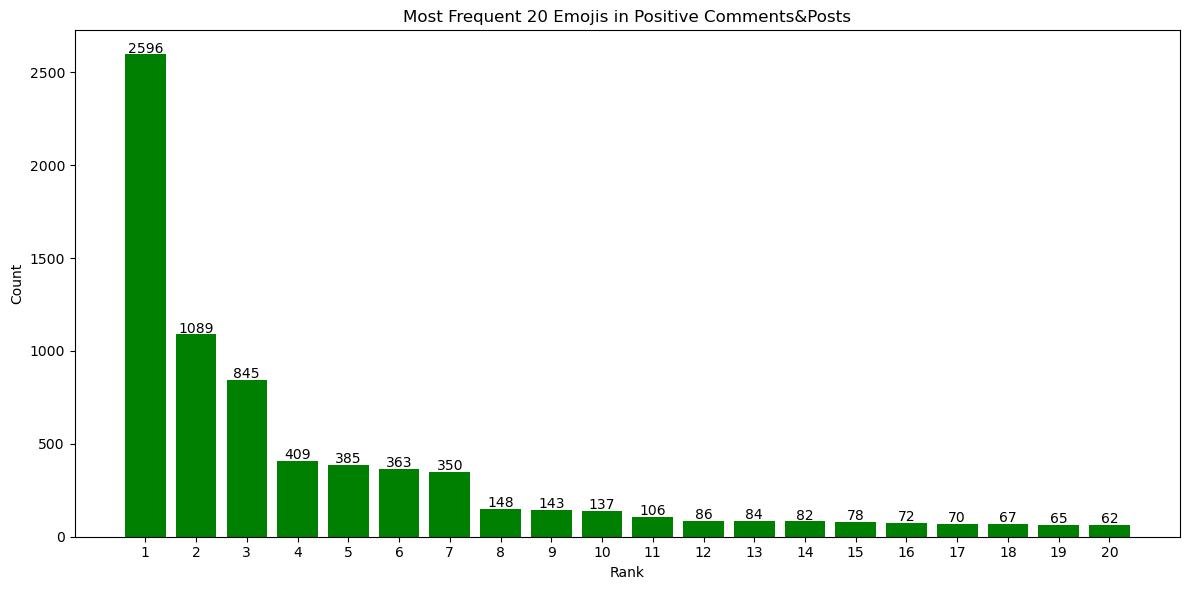

In [55]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the font
font = {'family': 'DejaVu Sans'}
plt.rc('font', **font)

# Get the data for the plot
positive_emoji_labels = positive_most_frequent_emojis.index
positive_emoji_counts = positive_most_frequent_emojis['Count']

# Create the bar plot
plt.bar(range(len(positive_emoji_labels)), positive_emoji_counts,color='green')

# Set the x-axis tick labels
plt.xticks(range(len(positive_emoji_labels)), positive_emoji_labels, fontsize=10)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Most Frequent 20 Emojis in Positive Comments&Posts')

# Add the count values as text above each bar
for i, count in enumerate(positive_emoji_counts):
    plt.text(i, count + 10, str(count), ha='center')

# Save the plot as a transparent image
plt.savefig('ttop_20_emojis.png', transparent=True)

# Display the plot
plt.tight_layout()
plt.show()


In [49]:
# Extract emojis from the 'text' column in df_positive
df_positive['emojis'] = df_positive['text'].apply(extract_emojis)

# Flatten the list of emojis
positive_emojis = [emoji for sublist in df_positive['emojis'] for emoji in sublist]

# Count the frequency of each emoji
positive_emoji_freqdist = pd.Series(positive_emojis).value_counts().reset_index()

# Rename the columns
positive_emoji_freqdist.columns = ['Emoji', 'Count']

# Show the most frequent emojis with rank (with rank header)
positive_most_frequent_emojis = positive_emoji_freqdist.head(20)
positive_most_frequent_emojis.index.name = 'Rank'




# Apply the styles to the DataFrame
positive_styled_df = positive_most_frequent_emojis.style.set_properties(**dict(styles))

# Convert the styled DataFrame to a regular DataFrame
positive_styled_df = positive_most_frequent_emojis.style.set_properties(**dict(styles)).data

# Reset the index to start from 1
positive_styled_df.index += 1

# Display the first 10 rows
display(HTML(positive_styled_df.head(10).to_html(index=True)))

# Display the last 10 rows
display(HTML(positive_styled_df.tail(10).to_html(index=True)))
# Display the styled DataFrame
#display(negative_styled_df)

,Emoji,Count
Rank,,
1,🚀,2596
2,🚀🚀🚀,1089
3,💎,845
4,🚀🚀🚀🚀,409
5,🚀🚀,385
6,💎🙌,363
7,🚀🚀🚀🚀🚀,350
8,🚀🚀🚀🚀🚀🚀,148
9,🙌,143


,Emoji,Count
Rank,,
11,💎👐,106
12,🌈🐻,86
13,🌙,84
14,🚀🚀🚀🚀🚀🚀🚀,82
15,♂️,78
16,🚀🚀🚀🚀🚀🚀🚀🚀🚀,72
17,🌝,70
18,️,67
19,❤️,65


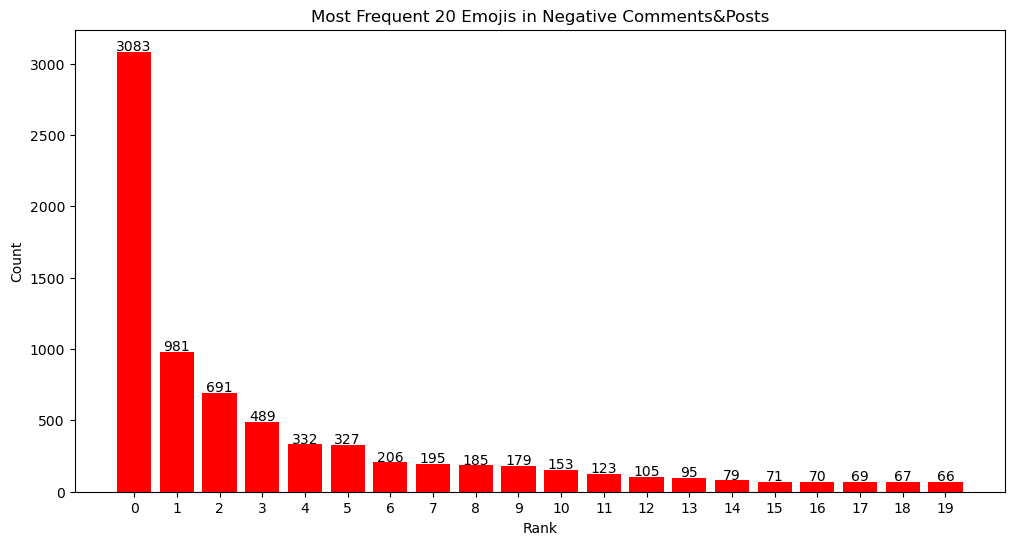

In [53]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the font
font = {'family': 'DejaVu Sans'}
plt.rc('font', **font)

# Get the data for the plot
emoji_labels = negative_most_frequent_emojis.index
emoji_counts = negative_most_frequent_emojis['Count']

# Create the bar plot
plt.bar(range(len(emoji_labels)), emoji_counts,color='red')

# Set the x-axis tick labels
plt.xticks(range(len(emoji_labels)), emoji_labels, fontsize=10)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Count')
plt.title('Most Frequent 20 Emojis in Negative Comments&Posts')

# Add the count values as text above each bar
for i, count in enumerate(emoji_counts):
    plt.text(i, count + 10, str(count), ha='center')

# Save the plot as a transparent image
plt.savefig('top_20_emojis.png', transparent=True)
